In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 

from vehicle_model_DDPG2 import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_pb_91_150.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00005
BATCH_SIZE = 32 
DELAY_TRAINING = 5000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    actor_model.save_weights("./{}/actor_model_checkpoint".format(root))
    critic_model.save_weights("./{}/critic_model_checkpoint".format(root))
    target_actor.save_weights("./{}/target_actor_checkpoint".format(root))
    target_critic.save_weights("./{}/target_critic_checkpoint".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.plot(test_cycle)
    plt.show() 
    return env.history  
    


Trial 0

maximum steps, simulation is done ... 
elapsed_time: 20.099
Episode: 1 Exploration P: 1.0000 Total reward: -3705.5114041428083 SOC: 1.0000 Cumulative_SOC_deviation: 285.5435 Fuel Consumption: 850.0768

maximum steps, simulation is done ... 
elapsed_time: 14.305
Episode: 2 Exploration P: 1.0000 Total reward: -3761.226985468947 SOC: 1.0000 Cumulative_SOC_deviation: 289.6236 Fuel Consumption: 864.9908

maximum steps, simulation is done ... 
elapsed_time: 14.414
Episode: 3 Exploration P: 1.0000 Total reward: -3699.33834425674 SOC: 1.0000 Cumulative_SOC_deviation: 286.9426 Fuel Consumption: 829.9123

maximum steps, simulation is done ... 
elapsed_time: 13.942
Episode: 4 Exploration P: 1.0000 Total reward: -3691.263815225341 SOC: 1.0000 Cumulative_SOC_deviation: 285.4957 Fuel Consumption: 836.3069


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFl

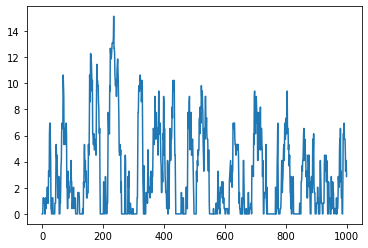

maximum steps, simulation is done ... 
elapsed_time: 55.390
Episode: 11 Exploration P: 0.7430 Total reward: -3003.536458164456 SOC: 1.0000 Cumulative_SOC_deviation: 236.0764 Fuel Consumption: 642.7724

maximum steps, simulation is done ... 
elapsed_time: 56.033
Episode: 12 Exploration P: 0.7073 Total reward: -3106.8777352592174 SOC: 1.0000 Cumulative_SOC_deviation: 246.7844 Fuel Consumption: 639.0337

maximum steps, simulation is done ... 
elapsed_time: 56.461
Episode: 13 Exploration P: 0.6732 Total reward: -2937.8412766249376 SOC: 1.0000 Cumulative_SOC_deviation: 235.0332 Fuel Consumption: 587.5089

maximum steps, simulation is done ... 
elapsed_time: 64.077
Episode: 14 Exploration P: 0.6408 Total reward: -2862.9786836614867 SOC: 0.9996 Cumulative_SOC_deviation: 229.3121 Fuel Consumption: 569.8573

maximum steps, simulation is done ... 
elapsed_time: 66.199
Episode: 15 Exploration P: 0.6100 Total reward: -2668.2275807265987 SOC: 1.0000 Cumulative_SOC_deviation: 214.0395 Fuel Consumpti

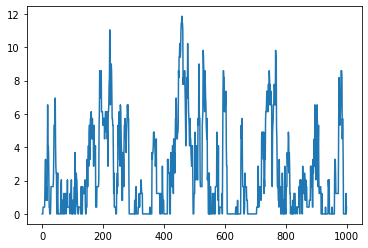

maximum steps, simulation is done ... 
elapsed_time: 52.908
Episode: 21 Exploration P: 0.4544 Total reward: -1940.748610804491 SOC: 0.9145 Cumulative_SOC_deviation: 155.5906 Fuel Consumption: 384.8421

maximum steps, simulation is done ... 
elapsed_time: 52.452
Episode: 22 Exploration P: 0.4327 Total reward: -2027.692283722177 SOC: 0.8786 Cumulative_SOC_deviation: 161.8783 Fuel Consumption: 408.9088

maximum steps, simulation is done ... 
elapsed_time: 52.935
Episode: 23 Exploration P: 0.4121 Total reward: -1792.5435649065023 SOC: 0.8894 Cumulative_SOC_deviation: 144.3924 Fuel Consumption: 348.6195

maximum steps, simulation is done ... 
elapsed_time: 52.098
Episode: 24 Exploration P: 0.3924 Total reward: -1743.2106848857732 SOC: 0.8773 Cumulative_SOC_deviation: 140.2865 Fuel Consumption: 340.3453

maximum steps, simulation is done ... 
elapsed_time: 52.649
Episode: 25 Exploration P: 0.3738 Total reward: -1854.37938270699 SOC: 0.9002 Cumulative_SOC_deviation: 148.3511 Fuel Consumption:

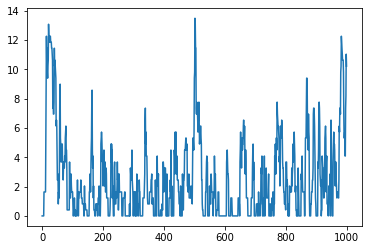

maximum steps, simulation is done ... 
elapsed_time: 56.820
Episode: 31 Exploration P: 0.2794 Total reward: -1276.6490447365493 SOC: 0.8019 Cumulative_SOC_deviation: 102.8607 Fuel Consumption: 248.0421

maximum steps, simulation is done ... 
elapsed_time: 57.139
Episode: 32 Exploration P: 0.2663 Total reward: -977.8993924675016 SOC: 0.7633 Cumulative_SOC_deviation: 74.3280 Fuel Consumption: 234.6195

maximum steps, simulation is done ... 
elapsed_time: 57.509
Episode: 33 Exploration P: 0.2537 Total reward: -1051.4741571659483 SOC: 0.7671 Cumulative_SOC_deviation: 84.5906 Fuel Consumption: 205.5679

maximum steps, simulation is done ... 
elapsed_time: 55.587
Episode: 34 Exploration P: 0.2418 Total reward: -1140.4239619481664 SOC: 0.7772 Cumulative_SOC_deviation: 92.1066 Fuel Consumption: 219.3582

maximum steps, simulation is done ... 
elapsed_time: 54.752
Episode: 35 Exploration P: 0.2305 Total reward: -1078.0439121864708 SOC: 0.7657 Cumulative_SOC_deviation: 86.6408 Fuel Consumption: 

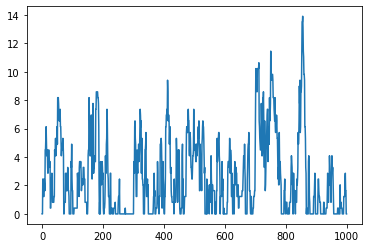

maximum steps, simulation is done ... 
elapsed_time: 54.779
Episode: 41 Exploration P: 0.1733 Total reward: -769.0545679450772 SOC: 0.7177 Cumulative_SOC_deviation: 61.4787 Fuel Consumption: 154.2678

maximum steps, simulation is done ... 
elapsed_time: 52.252
Episode: 42 Exploration P: 0.1653 Total reward: -679.0978864022134 SOC: 0.7070 Cumulative_SOC_deviation: 53.4575 Fuel Consumption: 144.5227

maximum steps, simulation is done ... 
elapsed_time: 51.869
Episode: 43 Exploration P: 0.1578 Total reward: -754.97029257016 SOC: 0.7200 Cumulative_SOC_deviation: 59.5738 Fuel Consumption: 159.2323

maximum steps, simulation is done ... 
elapsed_time: 53.526
Episode: 44 Exploration P: 0.1505 Total reward: -689.7768435585431 SOC: 0.7048 Cumulative_SOC_deviation: 54.7277 Fuel Consumption: 142.5001



In [ ]:
# print(env.version)

num_trials = 1
results_dict = {} 
# driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:1]

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes): 
        driving_cycle = driver.get_cycle() 
        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
    root = "DDPG2_trained"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [ ]:
with open("DDPG2.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# results_dict